In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
import string
import subprocess
from matplotlib import gridspec
import geopandas as gpd
from shapely.ops import unary_union
from matplotlib.patches import Patch
import matplotlib as mpl
import pycodamath
from sankeyflow import Sankey
from math import log as ln
from collections import defaultdict
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import country_converter as coco
import warnings
from textwrap import wrap

from src.diversities import *
from src.pca_functions import pca_biplot
from src.misc import query_db, extract_group

sns.set_context('paper')
os.makedirs('figs', exist_ok=True)

classPalette = {i+1: sns.color_palette('Dark2')[i] for i in range(3)}
alphabet = list(string.ascii_lowercase)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pycoda/pycoda.py:38: UserWarning: registration of accessor <class 'pycoda.pycoda.init.<locals>._'> under name 'coda' for type <class 'pandas.core.frame.DataFrame'> is overriding a preexisting attribute with the same name.
  @ pd.api.extensions.register_dataframe_accessor("coda")


# Data loading

## Country meta data

Data comes from Natural Earth Data: https://www.naturalearthdata.com/.

Countries: Built in GeoPandas.

Soverign regions: https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_0_sovereignty.zip

In [2]:
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
soverigns = gpd.read_file('world_data/ne_10m_admin_0_sovereignty/ne_10m_admin_0_sovereignty.shp')

soverignsToInclude = ['Malta', 'Singapore']
countries = pd.concat(
    [
        countries, 
        soverigns.loc[soverigns.NAME.isin(soverignsToInclude), ['NAME', 'geometry']].rename(columns={'NAME': 'name'})
    ]
)

## LAB-bacteriocin database

In [3]:
protMeta = pd.read_excel('bacteriocin_proteins_LAB_ONLY.xlsx', sheet_name='metadata')
protClusters = pd.read_excel('bacteriocin_proteins_LAB_ONLY.xlsx', sheet_name='clusters_100%', index_col=0)

protSel = pd.read_excel('bacteriocin_proteins_LAB_ONLY.xlsx', sheet_name='clusters100% LAB ONLY')
protSel = protSel.query("excluded == 0")
protSel['Class'] = protSel['Class'].replace('Unclassified', 0).astype(int, errors='ignore')

In [4]:
protMeta.groupby('database')['id'].nunique()

database
bactibase    224
bagel4       716
Name: id, dtype: int64

### Overlap between the BAGEL4 and BACTIBASE

In [5]:
clusterDict = protClusters.groupby(['clstr'])['cluster_members'].unique().to_dict()
n_bagel4, n_bactibase, n_overlaps = 0, 0, 0
for i, cmembers in clusterDict.items():
    cmembers = eval(cmembers[0])
    
    bagel4_hit, bactibase_hit = False, False
    for cmember in cmembers:
        if cmember.startswith('BAC'):
            n_bactibase += 1
            bactibase_hit = True
        else:
            n_bagel4 += 1
            bagel4_hit = True
        
    if all([bagel4_hit, bactibase_hit]):
        n_overlaps += 1
    
print("Number of unique clusters:", protClusters['clstr'].nunique())
print("Number of clusters with sequences from both databases:", n_overlaps)

Number of unique clusters: 629
Number of clusters with sequences from both databases: 184


## Sample metadata

In [6]:
with open('publication_data/used_samples.list', 'r') as f:
     usedRuns = [l.strip() for l in f.readlines()]

In [7]:
metaDF = pd.read_excel('publication_data/found_genuses_edited_genera_deleted.xlsx')
metaDF.rename(columns={'Catagory': 'category', 'Biome': 'biome'}, inplace=True)
metaDF = metaDF.query("biome != 'Lab'")
metaDF= metaDF.loc[metaDF.run_accession.isin(usedRuns), ]
print(metaDF.shape)

(14121, 20)


In [8]:
country2fix = {
    'USA': 'United States of America',
    'Democratic Republic of the Congo': 'Dem. Rep. Congo',
    'Czech Republic': 'Czechia',
    'North Pacific Ocean': 'Pacific Ocean',
    'South Pacific Ocean': 'Pacific Ocean',
    'North Atlantic Ocean': 'Atlantic Ocean',
    'South Atlantic Ocean': 'Atlantic Ocean',
    "Ivory Coast": "Côte d'Ivoire"
}

metaDF['country_fixed'] = metaDF['country'].map(country2fix).fillna(metaDF['country'])
metaDF.drop(columns=['country'], inplace=True)
metaDF.rename(columns={'country_fixed': 'country'}, inplace=True)

In [9]:
country2continent = {c: coco.convert(names=[c], to='Continent') for c in metaDF['country'].unique()}
metaDF['continent'] = metaDF['country'].map(country2continent).replace(['not found'], np.nan)
metaDF.dropna(subset=['continent'], inplace=True)

Baltic Sea not found in regex
Lake Ontario not found in regex
Lake Texoma not found in regex
Pacific Ocean not found in regex
North Sea not found in regex


### Coloring palettes

In [10]:
continentPalette = {
    c: sns.color_palette('Set1')[i] for i, c in enumerate(list(set(country2continent.values())))
}

categoryPalette = {
    category: sns.color_palette('Set3')[i] for i, category in enumerate(metaDF['category'].unique())
}
biomePalette = {
    biome: sns.color_palette('Accent')[i] for i, biome in enumerate(metaDF['biome'].unique())
}

In [11]:
biome2idx = {b: i for i, b in enumerate(biomePalette.keys())}
idxBiomePalette = {i: biomePalette[b] for b, i in biome2idx.items()}

category2idx = {b: i for i, b in enumerate(categoryPalette.keys())}
idxCategory2Palette = {i: categoryPalette[b] for b, i in category2idx.items()}

biome_handles = [Patch(facecolor='white', label='Biome')] + [Patch(facecolor=v, label=l) for l, v in biomePalette.items()] + [Patch(facecolor='white', label='')]
category_handles = [Patch(facecolor='white', label='Category')] + [Patch(facecolor=v, label=l) for l, v in categoryPalette.items()] + [Patch(facecolor='white', label='')]
class_handles = [Patch(facecolor='white', label='Class')] + [Patch(facecolor=v, label=l) for l, v in classPalette.items()] + [Patch(facecolor='white', label='')]
continent_handles = [Patch(facecolor='white', label='Continent')] + [Patch(facecolor=v, label=l) for l, v in continentPalette.items()] + [Patch(facecolor='white', label='')]


In [12]:
category2shortName = {
    'Animal': 'Anim.',
    'Algea': 'Algae',
    'Environmental': 'Env.',
    'Soil': 'Soil',
    'Fungi' : 'Fungi',
    'Food': 'Food',
    'Plant': 'Plant',
    
}

## Bacteriocin read counts

In [13]:
rerun = False

if rerun: 
    bacteriocins_anno = query_db("use AvA_2; select * from db_bacteriocins")

    bacteriocin_hits = query_db("use AvA_2; select * from bacteriocins")
    bacteriocin_hits_filtered = bacteriocin_hits.sort_values(by=['run_accession', 'qseqid', 'evalue']).drop_duplicates(subset=['run_accession', 'qseqid'], keep='first')
    bacteriocinCounts = bacteriocin_hits_filtered.groupby(['run_accession', 'sseqid']).agg({'qseqid': 'nunique'}).reset_index().rename(columns={'qseqid': 'read_count'})

    bac_names_replace = {
        '112.2;Lactacin_F,subunit_lafA': '112.2;Lactacin_F',
        '113.2;Lactacin_F,subunit_lafX': '113.2;Lactacin_F',
        '47.1;Lacticin_3147_A1': '47.1;Lacticin_3147_',
        '202.2;Sakacin_5XSakX': '202.2;Sakacin_5XSak',
    }
    
    bacteriocinCounts['sseqid2'] = bacteriocinCounts['sseqid']
    bacteriocinCounts['sseqid'] = bacteriocinCounts['sseqid'].map(bac_names_replace).fillna(bacteriocinCounts['sseqid2'])
    bacteriocinCounts.drop(columns=['sseqid2'], inplace=True)
    

    bacteriocinCounts2 = bacteriocinCounts.merge(
        bacteriocins_anno.pivot(index='gene', columns='category', values='category_value')[['length', 'Class', 'group_name']], 
        left_on='sseqid', right_index=True, how='left')
    bacteriocinCounts2['length_bp'] = bacteriocinCounts2['length'].astype(int) * 3
    bacteriocinCounts2['adj_count'] = bacteriocinCounts2['read_count'] / bacteriocinCounts2['length_bp']
    bacteriocinCounts2 = bacteriocinCounts2.merge(metaDF, on='run_accession', how='left')
    bacteriocinCounts2.drop(
        columns=[
            'Carnobacterium', 'Enterococcus', 'Lactococcus',
            'Leuconostoc', 'Oenococcus', 'Pediococcus', 'Streptococcus',
            'Weissella', 'Lactobacillus'
        ],
        inplace=True
    )
    
    bacteriocinCounts2['Class'] = bacteriocinCounts2['Class'].astype(int)
    
    bacteriocinCounts2.sort_values(by='run_accession').to_excel('publication_data/bacteriocin_hits.xlsx', index=None)
    
    bacteriocinCounts2.groupby('sseqid').agg(
        {
            'read_count': 'sum', 
            'biome': 'unique', 
            'category': 'unique', 
            'run_accession': 'nunique', 
            'project_accession': 'nunique'}
    ).sort_values(by='read_count').to_excel('publication_data/bacteriocin_summaries.xlsx')
else:
    bacteriocinCounts2 = pd.read_excel('publication_data/bacteriocin_hits.xlsx')

In [14]:
print("Number of run_accessions:", bacteriocinCounts2['run_accession'].nunique(), f"({bacteriocinCounts2['run_accession'].nunique() / metaDF['run_accession'].nunique() * 100:.2f})")
print("Number of sample_accessions:", bacteriocinCounts2['sample_accession'].nunique())
print("Number of project_accessions:", bacteriocinCounts2['project_accession'].nunique())

print("Number of countries:", bacteriocinCounts2['country'].nunique())
print("Number of hosts:", bacteriocinCounts2['host'].nunique())
print("Number of categories:", bacteriocinCounts2['category'].nunique())
print("Number of biomes:", bacteriocinCounts2['biome'].nunique())

Number of run_accessions: 1094 (8.21)
Number of sample_accessions: 981
Number of project_accessions: 118
Number of countries: 69
Number of hosts: 43
Number of categories: 7
Number of biomes: 3


### Calculate diversities of bacteriocins

In [15]:
bacteriocinDiversities = bacteriocinCounts2.pivot_table(
    index='run_accession', columns='sseqid', values='adj_count'
).apply(
    lambda x: [
        richness_diversity(x), 
        shannon_diversity(x), 
        gini_simpson_diversity(x)
    ], 
    axis=1, result_type='expand'
)
bacteriocinDiversities.rename(columns={0: 'Richness', 1: 'Shannon', 2: 'Gini-Simpson'}, inplace=True)
bacteriocinDiversities['category'] = 'Bacteriocin'
bacteriocinDiversities['tax_level'] = 'Proteins'

In [16]:
bacteriocinDiversities2 = bacteriocinDiversities.melt(
    ignore_index=False, 
    id_vars=['category', 'tax_level']
).merge(
    metaDF.drop(
        columns=[
            'Carnobacterium', 'Enterococcus', 'Lactococcus',
            'Leuconostoc', 'Oenococcus', 'Pediococcus', 'Streptococcus',
            'Weissella', 'Lactobacillus'
        ]
    ).set_index('run_accession'), 
    left_index=True, right_index=True
)

### Run PCA

In [17]:
bacteriocinClassCountsMat = bacteriocinCounts2.pivot_table(
    index='run_accession', columns='Class', values='adj_count', aggfunc='sum'
).fillna(0)

bacteriocinClass_PCA = pycodamath.pca.Biplot(
    bacteriocinClassCountsMat,
    default=False
)
plt.close()

bacteriocinSeqCountsMat = bacteriocinCounts2.pivot_table(
    index='run_accession', columns='sseqid', values='adj_count', aggfunc='sum'
).fillna(0)

bacteriocinSeq_PCA = pycodamath.pca.Biplot(
    bacteriocinSeqCountsMat,
    default=False,
)
plt.close()

Dataframe contains zeros. Using Bayesian inference to replace zeros.
Dataframe contains zeros. Using Bayesian inference to replace zeros.
Dataframe contains zeros. Using Bayesian inference to replace zeros.
Dataframe contains zeros. Using Bayesian inference to replace zeros.
Dataframe contains zeros. Using Bayesian inference to replace zeros.
Dataframe contains zeros. Using Bayesian inference to replace zeros.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


## Microbiome data

In [18]:
bacDF = pd.read_csv('publication_data/all_bac_counts.csv', header=None)
bacDF.columns=['run_accession', 'genus_name', 'species_name', 'fragmentCountAln']
bacDF.dropna(subset=['genus_name', 'species_name'], inplace=True)

In [19]:
# rename relevant lab
newnamesLAB = pd.read_excel('publication_data/all_LAB_species_incl_new_genera_reclass.xlsx', usecols=[0,1],sheet_name='Reclassification Lactobacillus')
bacDF2 = bacDF.merge(newnamesLAB, left_on='species_name', right_on='Old name', how='left')
bacDF2['New name'].fillna(bacDF2['species_name'], inplace=True)
bacDF2.drop(columns=['species_name', 'Old name'], inplace=True)
bacDF2.rename(columns={'New name': 'species_name'}, inplace=True)

### LAB-species

In [20]:
genusSpecies = pd.read_excel('publication_data/all_LAB_species_incl_new_genera_reclass.xlsx', usecols=[0,1])
genusSpecies = genusSpecies.loc[genusSpecies['Genus'].isin(metaDF.columns[-9:])]
newnamesLAB = pd.read_excel('publication_data/all_LAB_species_incl_new_genera_reclass.xlsx', usecols=[0,1],sheet_name='Reclassification Lactobacillus')
newnamesLAB[['old_genus', 'old_specie']] = newnamesLAB['Old name'].str.split(' ', expand=True, n=1)
genusSpecies = genusSpecies.merge(
    newnamesLAB, left_on=['Genus', 'Specie'], 
    right_on=['old_genus', 'old_specie'], how='left'
).drop(columns=['old_genus', 'old_specie'])

genusSpecies['New name'].fillna(genusSpecies.apply(lambda x: " ".join([x['Genus'], x['Specie']]), axis=1), inplace=True)

labDF = bacDF2.loc[bacDF2['species_name'].isin(genusSpecies['New name'].unique())]

### QPS-LAB

In [21]:
QPSLab = pd.read_excel('publication_data/all_LAB_species_QPS_status.xlsx')
QPSLab = QPSLab.loc[QPSLab['QPS status'] == 'Yes', ]
qpsLABDF = bacDF2.loc[bacDF2['species_name'].isin(QPSLab['New name'].unique())]

#### Calculate microbiome diversities

In [22]:
fname = 'publication_data/microbiome_diversities.csv'
rerun = False
if rerun:
    # for LAB in the samples
    labGenusDF2= labDF.pivot_table(index='run_accession', columns='genus_name', values='fragmentCountAln', aggfunc='sum').apply(lambda x: [richness_diversity(x), shannon_diversity(x), gini_simpson_diversity(x)], axis=1, result_type='expand')
    labGenusDF2[['tax_level', 'category']] = ['Genus', 'LAB']
    
    diversities = labGenusDF2
    diversities.to_csv(fname)
    print("LAB-genus done")
    
    labSpeciesDF2= labDF.pivot_table(index='run_accession', columns='species_name', values='fragmentCountAln', aggfunc='sum').apply(lambda x: [richness_diversity(x), shannon_diversity(x), gini_simpson_diversity(x)], axis=1, result_type='expand')
    labSpeciesDF2[['tax_level', 'category']] = ['Species', 'LAB']
   
    diversities = pd.concat([diversities, labSpeciesDF2])
    diversities.to_csv(fname)
    print("LAB-species done")

    # for QPS-LAB in the smaples    
    qpslabGenusDF2= qpsLABDF.pivot_table(index='run_accession', columns='genus_name', values='fragmentCountAln', aggfunc='sum').apply(lambda x: [richness_diversity(x), shannon_diversity(x), gini_simpson_diversity(x)], axis=1, result_type='expand')
    qpslabGenusDF2[['tax_level', 'category']] = ['Genus', 'QPS-LAB']
    
    diversities = pd.concat([diversities, qpslabGenusDF2])
    diversities.to_csv(fname)
    print("QPS-LAB-genus done")
   
    qpslabSpeciesDF2= qpsLABDF.pivot_table(index='run_accession', columns='species_name', values='fragmentCountAln', aggfunc='sum').apply(lambda x: [richness_diversity(x), shannon_diversity(x), gini_simpson_diversity(x)], axis=1, result_type='expand')
    qpslabSpeciesDF2[['tax_level', 'category']] = ['Species', 'QPS-LAB']
    
    diversities = pd.concat([diversities, qpslabSpeciesDF2])
    diversities.to_csv(fname)
    print("QPS-LAB-species done")
    
    # for all microbiomes in the samples
    bacGenusDF2= bacDF2.pivot_table(index='run_accession', columns='genus_name', values='fragmentCountAln', aggfunc='sum').apply(lambda x: [richness_diversity(x), shannon_diversity(x), gini_simpson_diversity(x)], axis=1, result_type='expand')
    bacGenusDF2[['tax_level', 'category']] = ['Genus', 'Microbiome']
    
    diversities = pd.concat([diversities, bacGenusDF2])
    diversities.to_csv(fname)
    print("Bac-genus done")
    
    bacSpeciesDF2= bacDF2.pivot_table(index='run_accession', columns='species_name', values='fragmentCountAln', aggfunc='sum').apply(lambda x: [richness_diversity(x), shannon_diversity(x), gini_simpson_diversity(x)], axis=1, result_type='expand')
    bacSpeciesDF2[['tax_level', 'category']] = ['Species', 'Microbiome']
    
    diversities = pd.concat([diversities, bacSpeciesDF2])
    diversities.to_csv(fname)
    print("Bac-species done")    

else:
    diversities = pd.read_csv(fname, index_col=0)
    

In [23]:
diversitiesMelt = diversities.melt(ignore_index=False, id_vars=['tax_level', 'category'])
diversitiesMelt2 = diversitiesMelt.merge(
    metaDF.drop(
        columns=[
            'Carnobacterium', 'Enterococcus', 'Lactococcus',
            'Leuconostoc', 'Oenococcus', 'Pediococcus', 'Streptococcus',
            'Weissella', 'Lactobacillus'
        ]
    ).set_index('run_accession'), 
    left_index=True, right_index=True
)

In [24]:
concatDiversities = pd.concat([diversitiesMelt2,bacteriocinDiversities2])
concatDiversities['variable2'] = concatDiversities[['category_x','tax_level','variable']].apply(lambda x: "_".join(x), axis=1)
concatDiversities2 = concatDiversities.reset_index().pivot_table(index=['run_accession', 'biome', 'category_y', 'country', 'continent'],columns=['variable2'], values='value')

# Main figures and tables

## Table 1

In [25]:
# WITH QPS-LAB
print("Number of run_accessions:", metaDF['run_accession'].nunique())
print("Number of sample_accessions:", metaDF['sample_accession'].nunique())
print("Number of project_accessions:", metaDF['project_accession'].nunique())

print("Number of countries:", metaDF['country'].nunique())
print("Number of hosts:", metaDF['host'].nunique())
print(f"Number of biomes: {metaDF['biome'].nunique()} ({', '.join(metaDF['biome'].unique().tolist())})")
print(f"Number of categories: {metaDF['category'].nunique()} ({', '.join(sorted(metaDF['category'].unique().tolist()))}) ")


Number of run_accessions: 13321
Number of sample_accessions: 11632
Number of project_accessions: 994
Number of countries: 96
Number of hosts: 327
Number of biomes: 3 (Urban, Wild, Agriculture)
Number of categories: 8 (Algea, Animal, Environmental, Food, Fungi, Plant, Protist, Soil) 


In [26]:
# WITH bacteriocin reads
print("Number of run_accessions:", bacteriocinCounts2['run_accession'].nunique(), f"({bacteriocinCounts2['run_accession'].nunique() / metaDF['run_accession'].nunique() * 100:.2f})")
print("Number of sample_accessions:", bacteriocinCounts2['sample_accession'].nunique())
print("Number of project_accessions:", bacteriocinCounts2['project_accession'].nunique())

print("Number of countries:", bacteriocinCounts2['country'].nunique())
print("Number of hosts:", bacteriocinCounts2['host'].nunique())
print("Number of categories:", bacteriocinCounts2['category'].nunique())
print("Number of biomes:", bacteriocinCounts2['biome'].nunique())

Number of run_accessions: 1094 (8.21)
Number of sample_accessions: 981
Number of project_accessions: 118
Number of countries: 69
Number of hosts: 43
Number of categories: 7
Number of biomes: 3


## Table 2

In [27]:
bacteriocinOverview = bacteriocinCounts2.groupby(['Class']).agg(
    {
        'run_accession': 'nunique', 
        'sseqid': 'nunique',
        'biome': 'nunique',
        'category': 'nunique',
        'country': 'nunique'

    }
)
bacteriocinOverview

,run_accession,sseqid,biome,category,country
Class,,,,,
1,355,12,3,2,48
2,907,58,3,5,64
3,352,3,3,5,37


## Table 3

In [28]:
sseqSumCounts = bacteriocinCounts2.groupby(['group_name']).agg(
    {
        'run_accession': 'nunique', 
        'read_count': 'sum', 
        'adj_count': 'sum',
        'sseqid': 'nunique',
 #       'sseqid': 'nunique',
        'Class': 'unique'
    }
).sort_values(by='read_count')
sseqSumCounts.to_excel('publication_data/sseqs_read_counts_sum.xlsx')
sseqSumCounts.tail(3).T

group_name,amylovorin,helveticin,plantaricin
run_accession,81,226,153
read_count,6956,32768,57097
adj_count,35.671795,42.592098,355.468992
sseqid,1,2,13
Class,[2],[3],"[2, 1]"


## Figure 1

/var/folders/xn/wtz0b0kn1nlcb56q5mn_b8zw0000gp/T/ipykernel_44816/2367118539.py:65: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, shrink=.4, label='No. Samples ($\log_{10}$)')


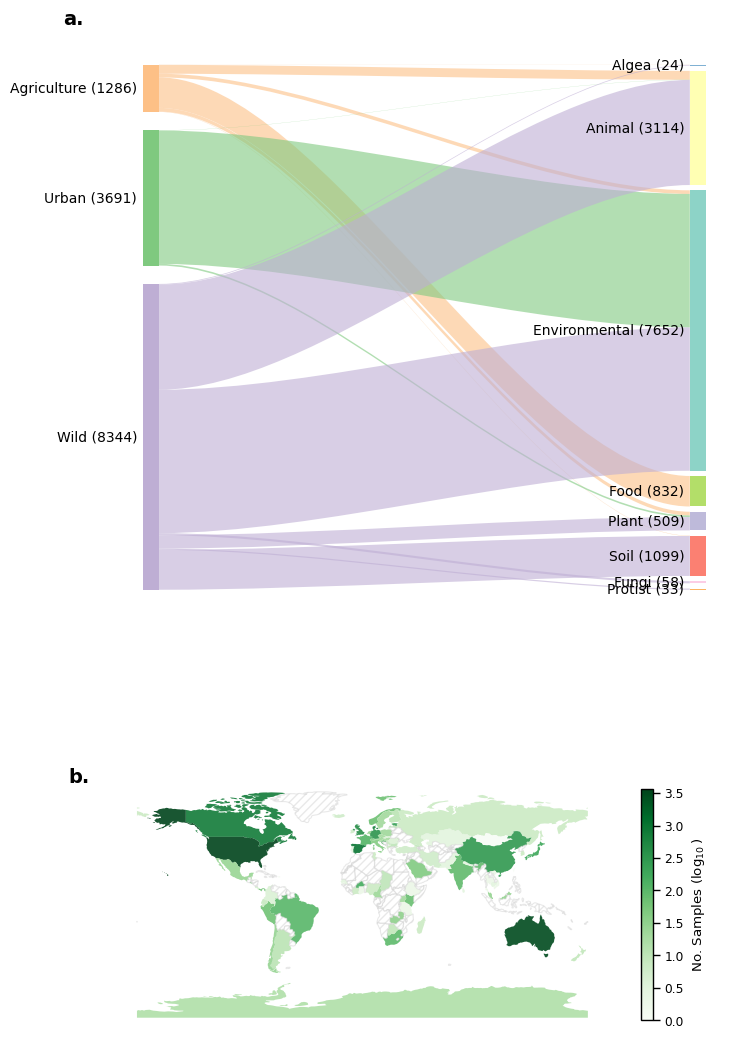

In [29]:
fig = plt.figure(figsize=(8,15))
gs = gridspec.GridSpec(ncols=1, nrows=2, hspace=0)#, height_ratios=[.75, 1])

ax_sankey = fig.add_subplot(gs[0])
ax_map = fig.add_subplot(gs[1])

flows = metaDF.groupby(['biome', 'category']).agg({'run_accession': 'nunique'}).reset_index().values.tolist() 

flow_color_mode = 'dest'

flow_color_dict = {
    'dest': biomePalette,
    'source': categoryPalette
}

s = Sankey(
    flows=flows,
    flow_color_mode = flow_color_mode,
    node_opts=dict(
        label_format='{label} ({value})',
        label_opts=dict(fontsize=10)
    )
    
)


for k, c in biomePalette.items():
    s.find_node(k)[0].color = c 
    
for k, c in categoryPalette.items():
    s.find_node(k)[0].color = c

    
for i, flow in enumerate(flows):
    c = flow_color_dict[flow_color_mode][flow[int(flow_color_mode == 'source')]]
    s.flows[i].color = tuple(list(c) + [.6])

s.draw(ax=ax_sankey)


countryCounts = metaDF.groupby('country').agg({'run_accession': 'nunique'})
countryCounts['log'] = np.log10(countryCounts['run_accession'])

min_kwds = {
        "color": "white",
        "hatch": "////",
        "label": "No samples",
        "alpha": 0.5,
        "edgecolor": "lightgrey"
    }

column = 'log'
vmin, vmax = countryCounts[column].describe()[['min', 'max']].values

countries.merge(countryCounts, left_on='name', right_index=True, how='left').plot(
    column=column,
    alpha=.9,
    ax = ax_map,
    cmap = 'Greens',
    vmin = vmin,
    vmax = vmax,
    missing_kwds=min_kwds
)
sm = plt.cm.ScalarMappable(cmap='Greens', norm=plt.Normalize(vmin=vmin, vmax=vmax))
plt.colorbar(sm, shrink=.4, label='No. Samples ($\log_{10}$)')

ax_map.axis('off')

for ax, label in zip([ax_sankey, ax_map], alphabet):
    ax.text(-0.05, 1.05, label + '.', transform=ax.transAxes, fontsize=14, va='top', ha='right', fontweight='bold')

fig.savefig('figs/fig1_sample_overviews.png', bbox_inches='tight')
fig.savefig('figs/fig1_sample_overviews.pdf', bbox_inches='tight')
fig.savefig('figs/fig1_sample_overviews.tiff', bbox_inches='tight')

## Figure 2

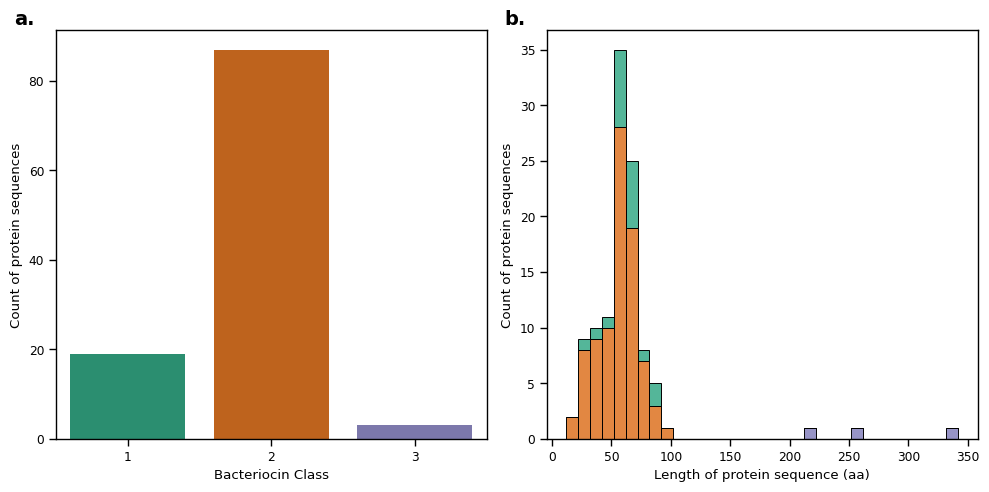

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))
sns.barplot(
    data=protSel.query("Class != 0").groupby('Class')['id'].nunique().reset_index(),
    x = 'Class',
    y = 'id',
    palette=classPalette,
    ax = axes[0],
)

axes[0].set_xlabel('Bacteriocin Class')
axes[0].set_ylabel('Count of protein sequences')

sns.histplot(
    data= protSel.query("Class != 0"),
    x = 'length',
    hue = 'Class',
    palette = classPalette,
    binwidth=10,
    ax = axes[1],
    legend=None,
    multiple='stack'
)
axes[1].set_ylabel('Count of protein sequences')
axes[1].set_xlabel('Length of protein sequence (aa)')

for ax, label in zip(axes.flatten(), alphabet):
    ax.text(-0.05, 1.05, label + '.', transform=ax.transAxes, fontsize=14, va='top', ha='right', fontweight='bold')
    
fig.tight_layout()

fig.savefig('figs/fig2_bacteriocin_db.png')
fig.savefig('figs/fig2_bacteriocin_db.pdf')
fig.savefig('figs/fig2_bacteriocin_db.tiff')

In [31]:
protSel.groupby('Class')['length'].describe()

,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
0,1.0,28.000000,NaN,28.0,28.0,28.0,28.0,28.0
1,19.0,61.263158,15.084363,30.0,57.0,59.0,66.0,91.0
2,87.0,55.000000,16.776922,12.0,43.5,56.0,64.0,101.0
3,3.0,267.000000,60.893349,213.0,234.0,255.0,294.0,333.0


## Figure 3

In [32]:
relAbundances = bacteriocinCounts2.pivot_table(
    index=['country', 'biome', 'category', 'run_accession'], columns='Class', values='adj_count', aggfunc='sum'
).fillna(0).coda.closure(100).reset_index()

In [33]:
clasSumCounts = bacteriocinCounts2.groupby(['Class']).agg({'adj_count': 'sum'})


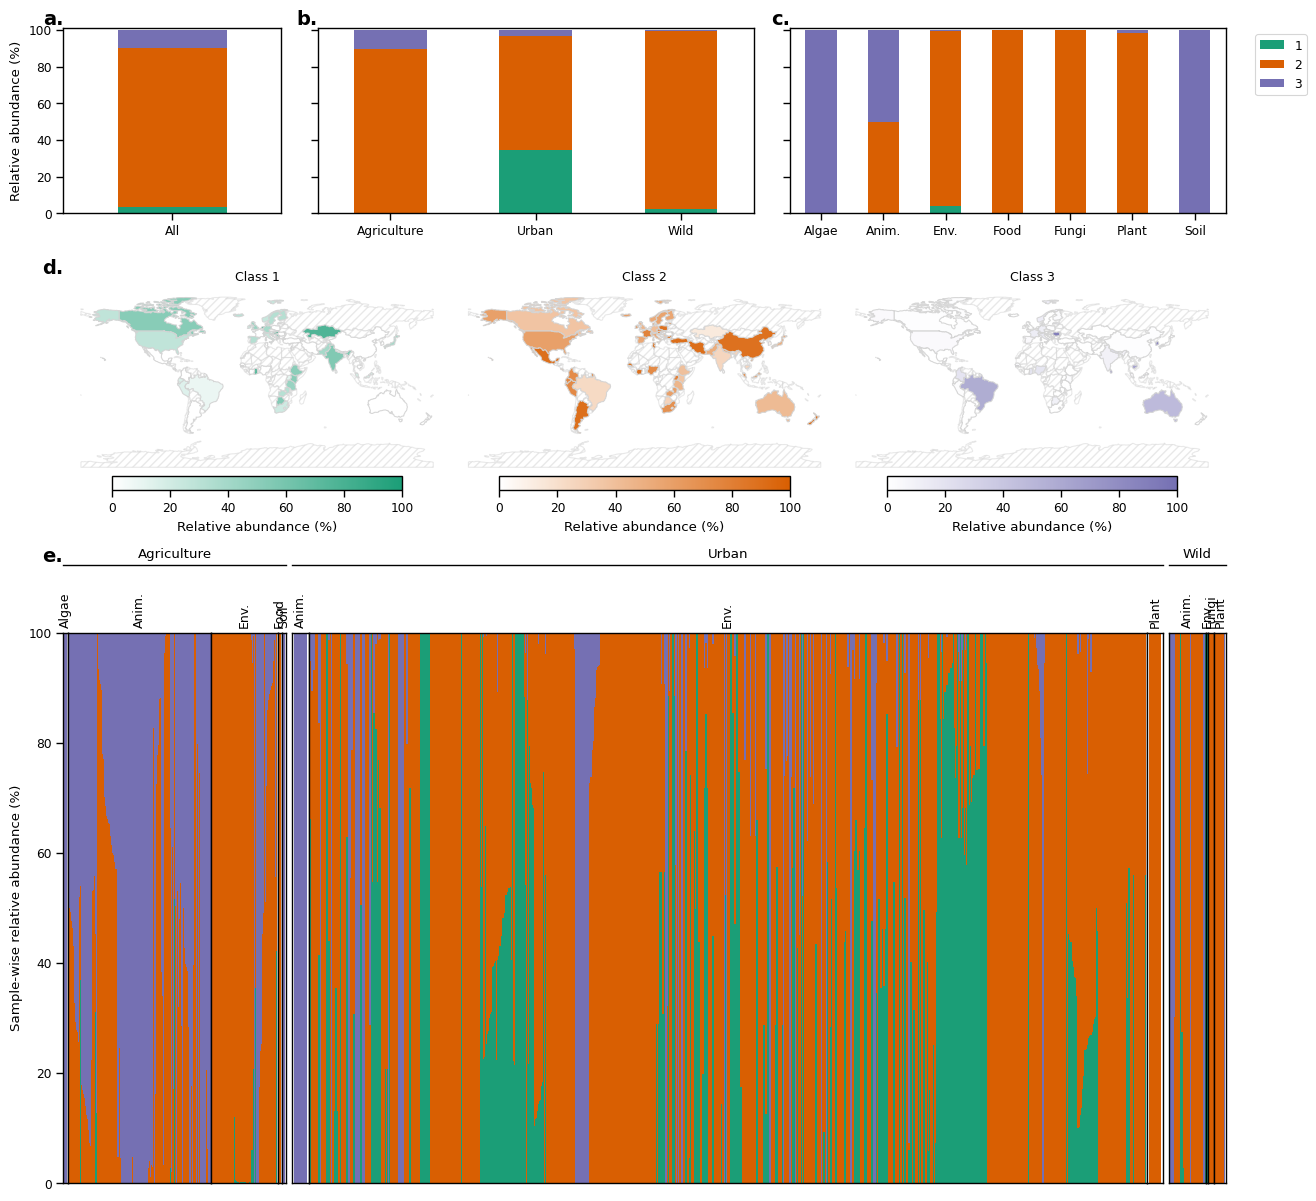

In [34]:
plotCols = sorted(relAbundances['biome'].unique().tolist())

plotMinWidth = 0.05
widthRatios = relAbundances['biome'].sort_values().value_counts(normalize=True, sort=False)
widthRatios[widthRatios<plotMinWidth] = plotMinWidth


fig = plt.figure(figsize=(15,15))

gs_main = gridspec.GridSpec(
    nrows=3, ncols=1,
    height_ratios=[.3, .4, 1],
    hspace=.15
)

ax_top = fig.add_subplot(gs_main[0])
ax_middle = fig.add_subplot(gs_main[1])
ax_bottom = fig.add_subplot(gs_main[-1])

for ax in [ax_top, ax_middle, ax_bottom]:
    ax.axis('off')

    
### group-wise ###
gs_sum = gridspec.GridSpecFromSubplotSpec(
    nrows=1, ncols=3,
    width_ratios=[.5, 1, 1],
    subplot_spec=gs_main[0],
    wspace=.1,
)

ax_bacteriocin_sum = fig.add_subplot(gs_sum[0])
ax_bacteriocin_biome = fig.add_subplot(gs_sum[1], sharey=ax_bacteriocin_sum)
ax_bacteriocin_category = fig.add_subplot(gs_sum[2], sharey=ax_bacteriocin_sum)

clasSumCounts[['adj_count']].T.coda.closure(100).plot.bar(stacked=True, color=classPalette, ax=ax_bacteriocin_sum)

bacteriocinCounts2.pivot_table( 
    index='biome', columns='Class', values='adj_count', aggfunc='sum'
).fillna(0).coda.closure(100).plot.bar(stacked=True, color=classPalette, ax=ax_bacteriocin_biome)

bacteriocinCounts2.pivot_table(
    index='category', columns='Class', values='adj_count', aggfunc='sum'
).fillna(0).coda.closure(100).plot.bar(stacked=True, color=classPalette, ax=ax_bacteriocin_category)

ax_bacteriocin_sum.set_ylabel('Relative abundance (%)')

### world maps ###
gs_maps = gridspec.GridSpecFromSubplotSpec(
    nrows=1, ncols=3,
    width_ratios=[1, 1, 1],
    subplot_spec=gs_main[1],
    wspace=0
)
ax_map_c1 = fig.add_subplot(gs_maps[0])
ax_map_c2 = fig.add_subplot(gs_maps[1])
ax_map_c3 = fig.add_subplot(gs_maps[2])

bacteriocinCountries = bacteriocinCounts2.replace(country2fix).pivot_table( 
    index='country', columns='Class', values='adj_count', aggfunc='sum'
).fillna(0).coda.closure(100)



for ax, column in zip([ax_map_c1, ax_map_c2, ax_map_c3], ['1', '2', '3']):
    cdata = countries.merge(bacteriocinCountries, left_on='name', right_index=True, how='left')
    
    cdata.plot(
        column=int(column),
        alpha=.9,
        cmap = LinearSegmentedColormap.from_list(colors=['white', classPalette[int(column)]], name=f'Class {column}', N=256),
        missing_kwds=min_kwds,
        ax=ax,
        legend=True,
        legend_kwds={'orientation': 'horizontal', 'shrink': .75, 'pad': 0, 'label': 'Relative abundance (%)'},
        edgecolor='lightgray'
    )
    
    ax.axis('off')
    ax.set_title(f"Class {column}", fontsize=9)
    
### sample-wise ###

gs = gridspec.GridSpecFromSubplotSpec(
    nrows=1, ncols=len(plotCols), 
    wspace=0.015, 
    width_ratios=widthRatios,
    subplot_spec=gs_main[-1]
)

subplotMinWidth = 0.02

axes = []
for i, biome in enumerate(plotCols):
    ax = fig.add_subplot(gs[i])
    ax.set_title(biome)
    
    axes.append(ax)
    
    subData = relAbundances.loc[relAbundances.biome == biome]

    subCols = sorted(subData['category'].unique().tolist())
    
    widthRatiosSub = subData['category'].sort_values().value_counts(normalize=True, sort=False)
    widthRatiosSub[widthRatiosSub<subplotMinWidth] = subplotMinWidth
    
    gs00 = gridspec.GridSpecFromSubplotSpec(
        ncols=len(subCols), nrows=2, 
        subplot_spec=gs[i], 
        height_ratios=[.02, 1], 
        width_ratios=widthRatiosSub.values.tolist(),
        wspace=0
    )
    
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.spines[['bottom', 'left', 'right']].set_visible(False)
    
    for j, category in enumerate(subCols):
        ax_sub = fig.add_subplot(gs00[-1, j])
        
        subData2 = subData.loc[subData.category == category].sort_values(by=[1, 2, 3])
        ax_sub.set_title(category2shortName[category], fontdict={'fontsize': 9}, rotation=90)
        
        subData2.sort_values(by=['country'])[[1,2,3]].plot.bar(
            stacked=True, 
            color=classPalette, 
            ax=ax_sub,
            legend=None,
            align='center',
            width = 1,

        )
        
        ax_sub.xaxis.set_visible(False)
        ax_sub.set_xlabel('')
        if (i == 0 and j > 0) or i > 0:
            ax_sub.yaxis.set_visible(False)
        else:
            ax_sub.set_ylabel('Sample-wise relative abundance (%)')
        
        ax_sub.set_ylim(0, 100)
        
# put labels on each subplot
for i, (ax, l) in enumerate(zip([ax_bacteriocin_sum, ax_bacteriocin_biome, ax_bacteriocin_category, ax_middle, ax_bottom], alphabet)):
    if i < 3:
        ax.text(-0.0, 1.1, l + '.', transform=ax.transAxes, fontsize=14, va='top', ha='right', fontweight='bold')
        xticklabels = ax.get_xticklabels()    
        if i == 0:
            xticklabels = ['All']
        elif i == 2:
            xticklabels = [category2shortName[v.get_text()] for v in xticklabels]

        ax.set_xticklabels(xticklabels, rotation=0)    
        ax.set_ylim(0,101)
        if i < 2:
            ax.get_legend().remove()
        else:
            ax.legend(loc=1, bbox_to_anchor=(1.2, 1))
        ax.set_xlabel("")
    else:
        ax.text(-0.0, 1.03, l + '.', transform=ax.transAxes, fontsize=14, va='top', ha='right', fontweight='bold')        

fig.savefig('figs/fig2_overview_bacteriocin_hits.png', bbox_inches="tight")
fig.savefig('figs/fig2_overview_bacteriocin_hits.pdf', bbox_inches="tight")
fig.savefig('figs/fig2_overview_bacteriocin_hits.tiff', bbox_inches="tight")


## Figure 4

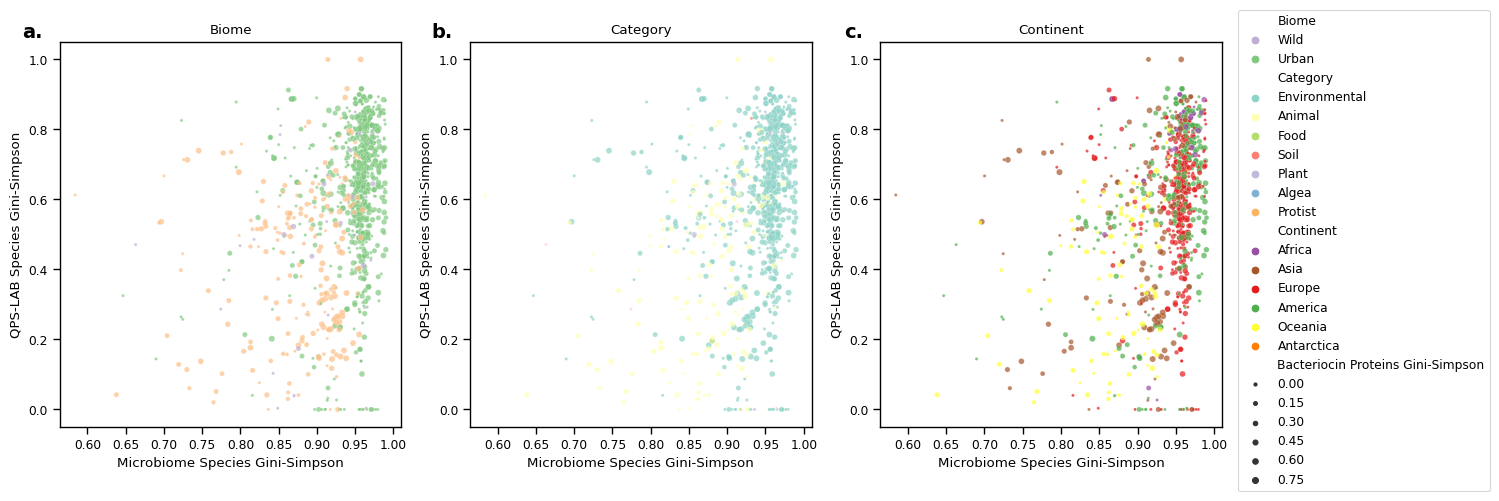

In [35]:
xp='Microbiome_Species_{}'
yp='QPS-LAB_Species_{}'
sp = 'Bacteriocin_Proteins_{}'

metrics = ['Gini-Simpson']
hues = ['biome', 'category_y', 'continent']
hue2palette = {'biome': biomePalette, 'category_y': categoryPalette, 'continent': continentPalette}
dim = 5
fig, axes = plt.subplots(len(metrics),len(hues), figsize=(dim*len(hues), dim*len(metrics)))

if any([len(metrics) > 1, len(hues)>1]):
    flat_axes = axes.flatten()
else:
    flat_axes = [axes]

plot_combis = [(m, c) for m in metrics for c in hues]
handles, labels = [], []
for i, (ax, plot_combi, label) in enumerate(zip(flat_axes, plot_combis, alphabet)):
    metric, hue = plot_combi
    x = xp.format(metric)
    y = yp.format(metric)
    size = sp.format(metric)
    
    hueRename = hue.split('_')[0].title()
    sizeRename = size.replace('_', ' ')

    dat = concatDiversities2.loc[concatDiversities2.index.get_level_values(level='continent') != 'not found'].copy()
    dat.index.set_names({hue: hueRename}, inplace=True)
    dat.rename(columns={size: sizeRename}, inplace=True)
    
    selPalette = hue2palette[hue]
    
    sns.scatterplot(
        data = dat,
        x = x,
        y = y,
        size = sizeRename,
        ax = ax,
        hue = hueRename,
        alpha = .7,
        palette = selPalette,
        legend='brief',
        sizes=(5, 20)
    )
    
    ax.set_xlabel(x.replace('_', ' '))
    ax.set_ylabel(y.replace('_', ' '))
    ax.set_title(hue.split('_')[0].title())
    handl, labl = ax.get_legend_handles_labels()
    if i < len(flat_axes)-1:
        
        handles += handl[0:len(hue2palette[hue]):]
        labels += labl[0:len(hue2palette[hue])]
        ax.get_legend().remove()
    else:
        handles += handl
        labels += labl
        ax.legend(handles=handles, labels=labels, loc='upper right', bbox_to_anchor=(1.8,1.1))
    
    ax.text(-0.05, 1.05, label + '.', transform=ax.transAxes, fontsize=14, va='top', ha='right', fontweight='bold')

fig.savefig('figs/fig4_microbiome_bacteriocins_diversities_ginisimpson.png', bbox_inches='tight')
fig.savefig('figs/fig4_microbiome_bacteriocins_diversities_ginisimpson.pdf', bbox_inches='tight')
fig.savefig('figs/fig4_microbiome_bacteriocins_diversities_ginisimpson.tiff', bbox_inches='tight')

## Figure 5

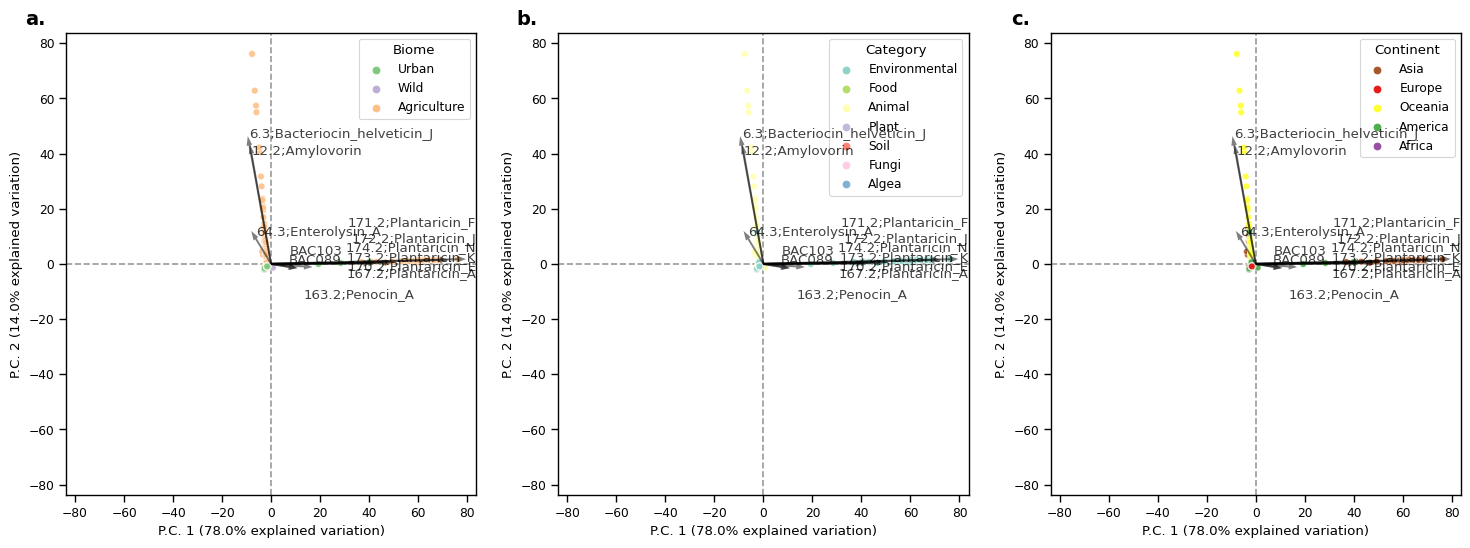

In [36]:
dim = 6
ncols = 3
nrows = 1
fig, axes = plt.subplots(nrows, ncols, figsize=(dim*ncols, dim*nrows))
colorpalettes = [biomePalette, categoryPalette, continentPalette]
colorgroups = ['biome', 'category', 'continent']
colorpalettes = [biomePalette, categoryPalette, continentPalette]


for j, (ax_top, colorgroup, colorPalette, label) in enumerate(
    zip(
        axes.flatten(), 
        colorgroups, colorpalettes,
        alphabet
    )
):
    pca_biplot(
        scores = bacteriocinSeq_PCA.scores,
        loadings= bacteriocinSeq_PCA.loadings,
        x = 'pc1',
        y = 'pc2',
        meta = metaDF.rename(columns={colorgroup: colorgroup.title()}),
        sample_key='run_accession',
        palette=colorPalette,
        colorgroup=colorgroup.title(),
        kinds=['scatter'],
        axis=ax_top,
        scatter_alpha=.9,
        cutoff=7
    )

    ax_top.set_xlabel(bacteriocinSeq_PCA.axis.get_xlabel())
    ax_top.set_ylabel(bacteriocinSeq_PCA.axis.get_ylabel())
    ax_top.text(-0.05, 1.05, label + '.', transform=ax_top.transAxes, fontsize=14, va='top', ha='right', fontweight='bold')
    
    handls, labls = ax_top.get_legend_handles_labels()
    ax_top.get_legend().remove()
    ax_top.legend(handles=handls, labels=labls, loc='upper right', title=colorgroup.title())

fig.savefig('figs/fig5_pca_bacteriocion_seq.png', bbox_inches='tight')
fig.savefig('figs/fig5_pca_bacteriocion_seq.pdf', bbox_inches='tight')
fig.savefig('figs/fig5_pca_bacteriocion_seq.tiff', bbox_inches='tight')
plt.show()

## Figure 6

In [37]:
# make matrices
plantaracinMat, plantaracinZRMat, plantaracinALR, plantaracinCLR = extract_group('plantaricin', bacteriocinCounts2, qpsLABDF)
helveticinMat, helveticinZRMat, helveticinALR, helveticinCLR = extract_group('helveticin', bacteriocinCounts2, qpsLABDF)
amylovorinMat, amylovorinZRMat, amylovorinALR, amylovorinCLR = extract_group('amylovorin', bacteriocinCounts2, qpsLABDF)

Using QPS-LAB as denominator.
Using QPS-LAB as denominator.
Dataframe contains zeros. Using Bayesian inference to replace zeros.
Using QPS-LAB as denominator.


In [38]:
selTypesPalette = {p: sns.color_palette()[i] for i, p in enumerate(['plantaricin', 'helveticin', 'amylovorin'])}
selTypes_handles = [Patch(facecolor='white', label='Bacteriocin')] + [Patch(facecolor=v, label=l.title()) for l, v in selTypesPalette.items()] + [Patch(facecolor='white', label='')]

In [39]:
selSeqCLR = pd.concat([plantaracinMat, helveticinMat, amylovorinMat], axis=1).fillna(0).coda.clr()
selSeqCLR['continent'] = selSeqCLR.index.get_level_values('country').map(country2continent)
selSeqCLR.dropna(subset='continent', inplace=True)
selSeqCLR.set_index('continent', append=True, inplace=True)

cols =  selSeqCLR.reset_index()[['run_accession', 'biome', 'category', 'continent']].drop_duplicates()
cols['Biome'] = cols['biome'].map(biomePalette)
cols['Category'] = cols['category'].map(categoryPalette)
cols['Continent'] = cols['continent'].map(continentPalette)
col_colors = cols.drop(columns=['biome', 'category', 'continent']).set_index('run_accession')

rows = pd.DataFrame({'sseqid': selSeqCLR.columns.get_level_values('sseqid')})
rows = rows.merge(bacteriocinCounts2[['sseqid', 'Class', 'group_name']].drop_duplicates(), on='sseqid')
rows['Class'] = rows['Class'].astype(int).map(classPalette)
rows['Bacteriocin'] = rows['group_name'].map(selTypesPalette)
row_colors =rows.drop(columns=['group_name']).set_index(['sseqid'])

Dataframe contains zeros. Using Bayesian inference to replace zeros.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


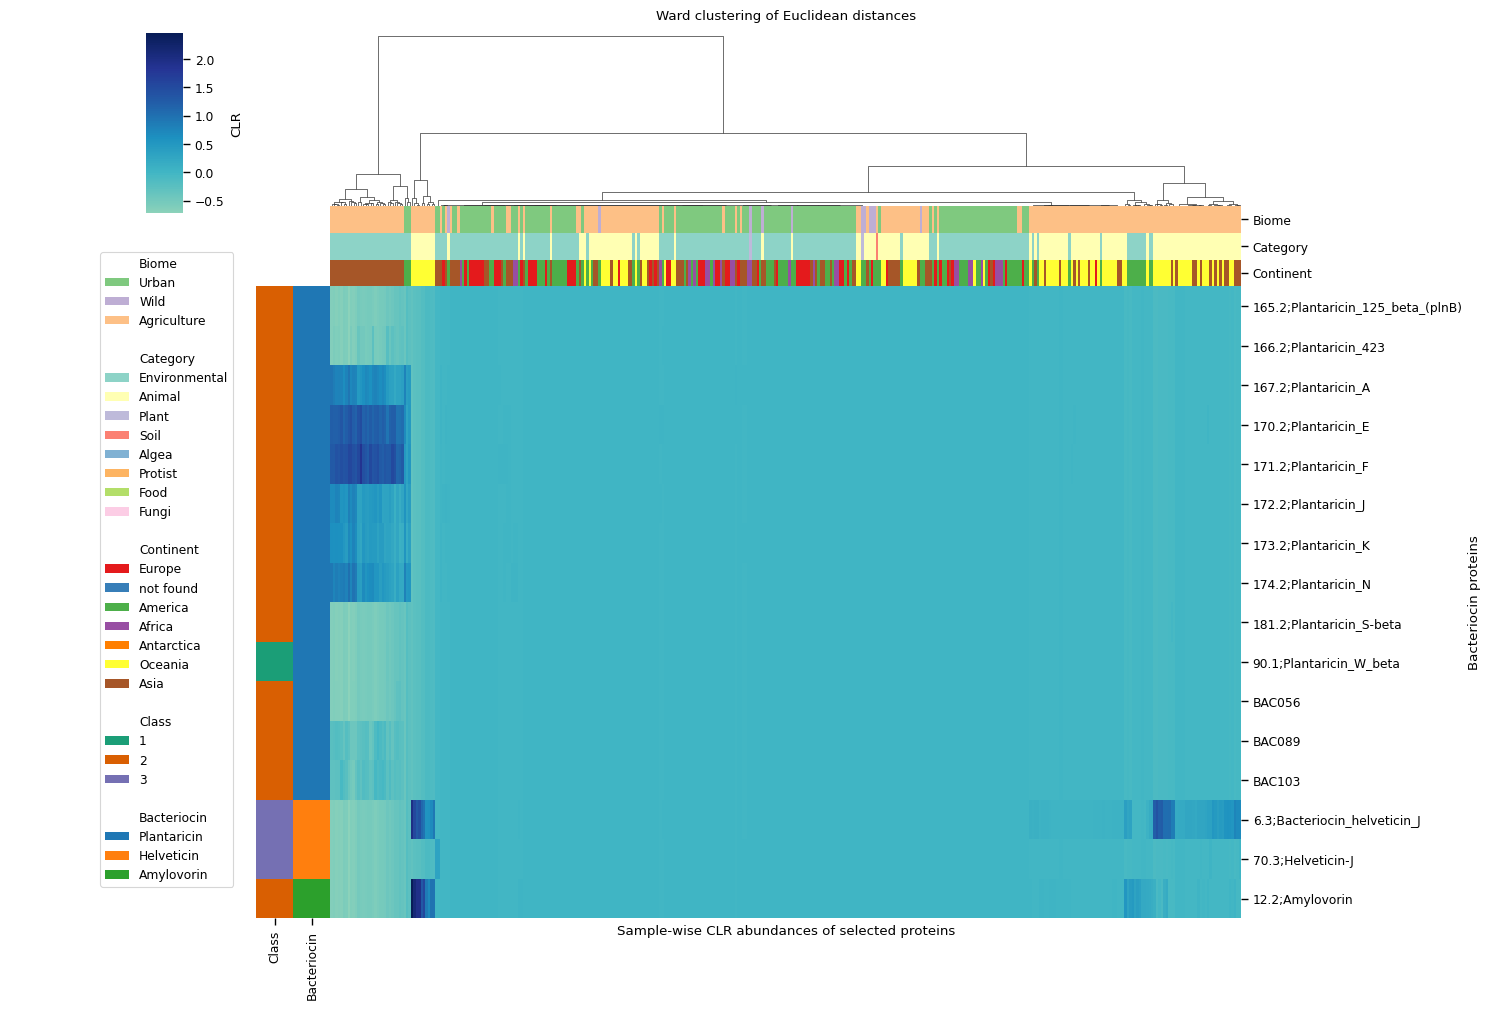

In [40]:
g_selBacteriocins_abns = sns.clustermap(
    data=selSeqCLR.reset_index(level=[1,2,3,4], drop=True).T,
    center=0,
    row_cluster=False,
    col_cluster=True,
    row_colors=row_colors,
    col_colors=col_colors,
    xticklabels=False,
    cbar_kws={'label': 'CLR', 'shrink': .5},
    cbar_pos=(0.1, 0.8, 0.025, 0.18),
    figsize=(15,10),
    yticklabels=True,
    method='ward',
    cmap='YlGnBu'
)
g_selBacteriocins_abns.ax_heatmap.set_xlabel('Sample-wise CLR abundances of selected proteins')
g_selBacteriocins_abns.ax_heatmap.set_ylabel('Bacteriocin proteins')
g_selBacteriocins_abns.ax_col_colors.legend(
    handles=biome_handles + category_handles + continent_handles + class_handles + selTypes_handles[:-1] , 
    loc=1, 
    bbox_to_anchor=(-0.1, .5)
)
g_selBacteriocins_abns.ax_col_dendrogram.set_title('Ward clustering of Euclidean distances')
g_selBacteriocins_abns.fig.savefig('figs/fig6_sel_proteins_clr_heatmap.png', bbox_inches="tight")
g_selBacteriocins_abns.fig.savefig('figs/fig6_sel_proteins_clr_heatmap.pdf', bbox_inches="tight")
g_selBacteriocins_abns.fig.savefig('figs/fig6_sel_proteins_clr_heatmap.tiff', bbox_inches="tight")

# Supplementary figures and tables

## Figure S1

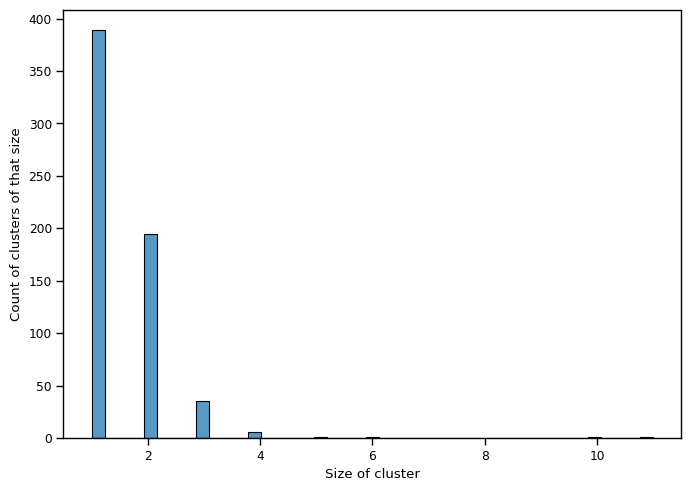

In [41]:
fig, ax = plt.subplots(figsize=(7,5)) 
sns.histplot(
    data = protClusters[['clstr', 'clstr_size']],
    x = 'clstr_size', 
    ax = ax
)
ax.set_xlabel('Size of cluster')
ax.set_ylabel('Count of clusters of that size')
fig.tight_layout()
fig.savefig('figs/figS1_clstr_sizes.png')
fig.savefig('figs/figS1_clstr_sizes.pdf')
fig.savefig('figs/figS1_clstr_sizes.tiff')

## Figure S2

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


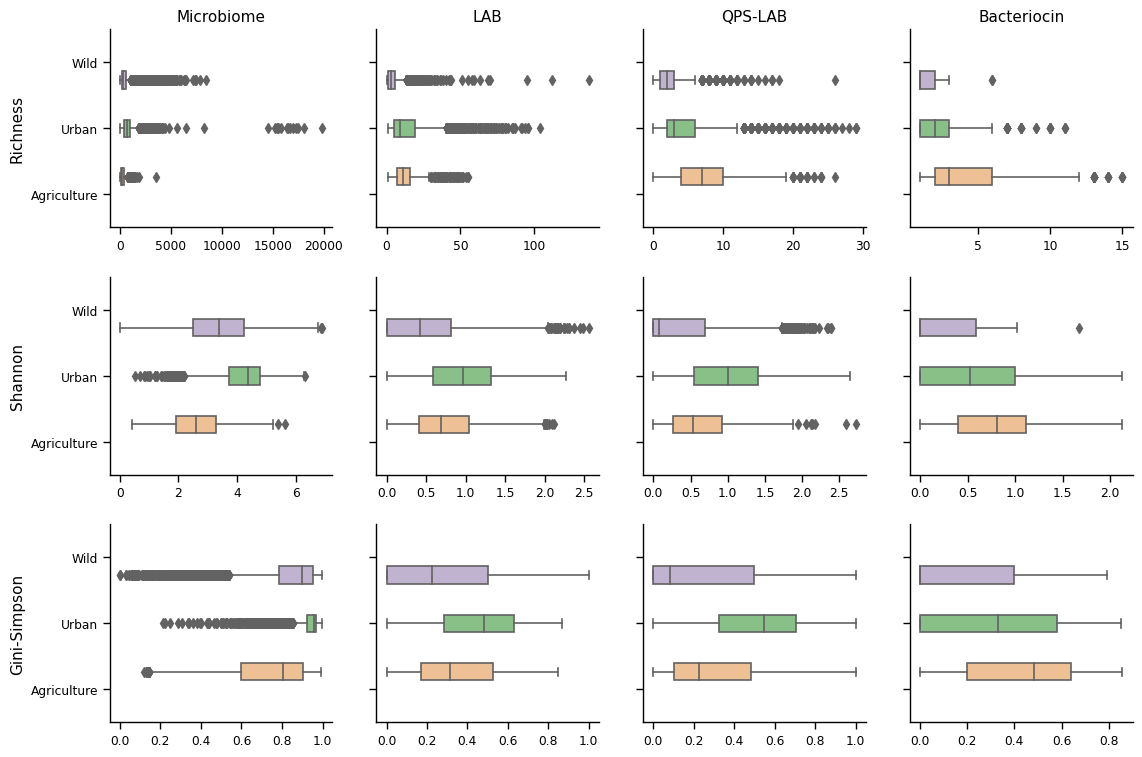

In [42]:
g_div_all = sns.catplot(
    data = concatDiversities.query("tax_level == 'Species' or tax_level=='Proteins'"),
    x = 'value',
    y = 'biome',
    hue = 'biome',
    kind='box',
    col = 'category_x',
    row= 'variable',
    col_order=['Microbiome', 'LAB', 'QPS-LAB', 'Bacteriocin'],
    row_order=['Richness', 'Shannon', 'Gini-Simpson'],
    sharex=False,
    palette=biomePalette,
    hue_order=['Agriculture', 'Urban', 'Wild'],
    height=3,
    facet_kws={'gridspec_kws': {'hspace': .25}},
)

for i, (k, ax) in enumerate(g_div_all.axes_dict.items()):
    
    if 'gini_simpson' in k[0]:
        xlabels = k[0].split('_')
        xlabel = "-".join(xlabels[:2]) + " " + xlabels[-1]
    else:
        xlabel = k[0].replace('_', ' ')
        
    
    if i <= 3: 
        ax.set_title(k[1], fontdict={'size': 11})
    else:
        ax.set_title('')
    
    if i % 4 == 0:
        ax.set_ylabel(xlabel.title(), fontdict={'size': 11})
    
    ax.set_xlabel('')
    
g_div_all.legend.remove()
g_div_all.fig.savefig('figs/figS2_alpha_diversities_specie.png', bbox_inches='tight')
g_div_all.fig.savefig('figs/figS2_alpha_diversities_specie.pdf', bbox_inches='tight')
g_div_all.fig.savefig('figs/figS2_alpha_diversities_specie.tiff', bbox_inches='tight')


## Figure S3

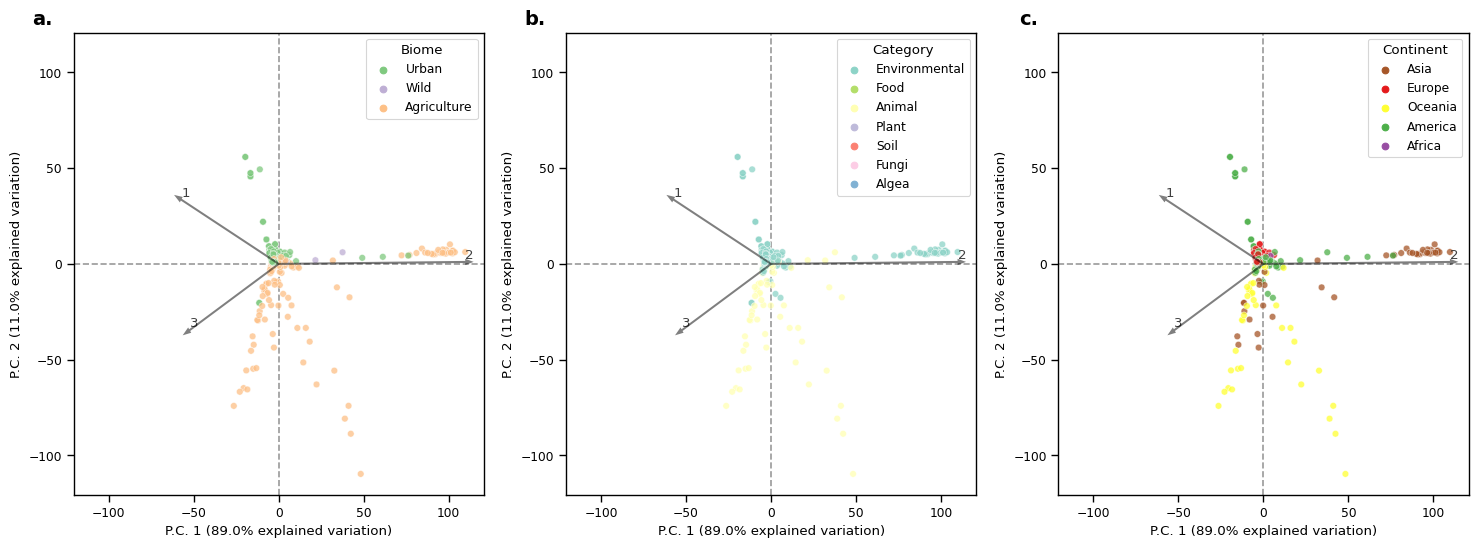

In [43]:
dim = 6
ncols = 3
nrows = 1
fig, axes = plt.subplots(nrows, ncols, figsize=(dim*ncols, dim*nrows))

for j, (ax, colorgroup, colorPalette, label) in enumerate(zip(axes.flatten(), ['biome', 'category', 'continent'], [biomePalette, categoryPalette, continentPalette], alphabet)):
    pca_biplot(
        scores = bacteriocinClass_PCA.scores,
        loadings= bacteriocinClass_PCA.loadings,
        x = 'pc1',
        y = 'pc2',
        meta = metaDF.rename(columns={colorgroup: colorgroup.title()}),
        sample_key='run_accession',
        palette=colorPalette,
        colorgroup=colorgroup.title(),
        kinds=['scatter'],
        axis=ax,
        scatter_alpha=.75
    )

    ax.set_xlabel(bacteriocinClass_PCA.axis.get_xlabel())
    ax.set_ylabel(bacteriocinClass_PCA.axis.get_ylabel())
    ax.text(-0.05, 1.05, label + '.', transform=ax.transAxes, fontsize=14, va='top', ha='right', fontweight='bold')
    
fig.savefig('figs/figS3_pca_bacteriocion_class.png', bbox_inches='tight')
fig.savefig('figs/figS3_pca_bacteriocion_class.pdf', bbox_inches='tight')
fig.savefig('figs/figS3_pca_bacteriocion_class.tiff', bbox_inches='tight')
plt.show()